In [2]:
# display inline plots
%matplotlib inline

# import libraries for numerical and scientific computing
import numpy as np

# import matplotlib for plotting
import matplotlib.pyplot as plt

# import pandas for data wrangling and munging
import pandas as pd

# set some options for better view
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# import plotting library built on top of matplotlib
import seaborn as sns

# set some settings related to style of plots that will render
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_excel('./data/train.xlsx', parse_dates=True)
test = pd.read_excel('./data/test.xlsx', parse_dates=True)

In [5]:
# set ID as index
train = train.set_index('ID')
test = test.set_index('ID')

In [6]:
# lowercase column names
train.columns = train.columns.map(lambda x: x.lower())
test.columns = test.columns.map(lambda x: x.lower())

## Summary statistics for salary

In [7]:
train.salary.describe()

count       3998.000000
mean      307699.849925
std       212737.499957
min        35000.000000
25%       180000.000000
50%       300000.000000
75%       370000.000000
max      4000000.000000
Name: salary, dtype: float64

In [8]:
# let us create different levels for salary - low, medium and high
def salary_map(salary):
    if salary < 2e5:
        return 'low_salary'
    elif salary < 4e5:
        return 'medium_salary'
    else:
        return 'high_salary'

train['salary_type'] = train.salary.map(salary_map)

In [9]:
# count of various salary types
train.salary_type.value_counts()

medium_salary    2050
low_salary       1066
high_salary       882
Name: salary_type, dtype: int64

In [ ]:
train.co

In [26]:
# distribution of college tier by salary types
g = train.groupby(['salary_type', 'collegetier']).size()
d = g.unstack(1)

d['percentage_1'] = d[1] / d.sum(axis=1)
d['percentage_2'] = d[2] / d.sum(axis=1)

In [33]:
d

collegetier,1,2,percentage_1,percentage_2
salary_type,,,,
high_salary,130,752,0.147392,0.852465
low_salary,20,1046,0.018762,0.981221
medium_salary,147,1903,0.071707,0.928260


In [76]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [77]:
features = ['10percentage', '12percentage', 'collegegpa', 'collegetier', 'graduationyear',
            'english', 'logical', 'quant', 'domain']

X = train[features]
y = train.salary

In [78]:
scaler = StandardScaler()
lm = LinearRegression()

clf = Pipeline([('scaler', scaler), ('lm', lm)])

In [79]:
clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [88]:
lm_comp = clf.get_params()['lm']

In [89]:
print 'Estimated intercept coefficient:', lm_comp.intercept_

Estimated intercept coefficient: 307699.849925


In [90]:
print 'Number of coefficients:', len(lm_comp.coef_)

Number of coefficients: 9


In [91]:
# The coefficients
pd.DataFrame(zip(X.columns, lm_comp.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,10percentage,8448.987220
1,12percentage,12255.573922
2,collegegpa,9649.341457
3,collegetier,-24698.336562
4,graduationyear,-976.223265
5,english,14197.905694
6,logical,6087.694365
7,quant,23578.071247
8,domain,10939.051083


In [92]:
# lets take a look at first five predicted values
clf.predict(X)[0:5]

array([ 350502.08339432,  412853.20317275,  287322.03124787,
        471654.07643211,  302408.31278987])

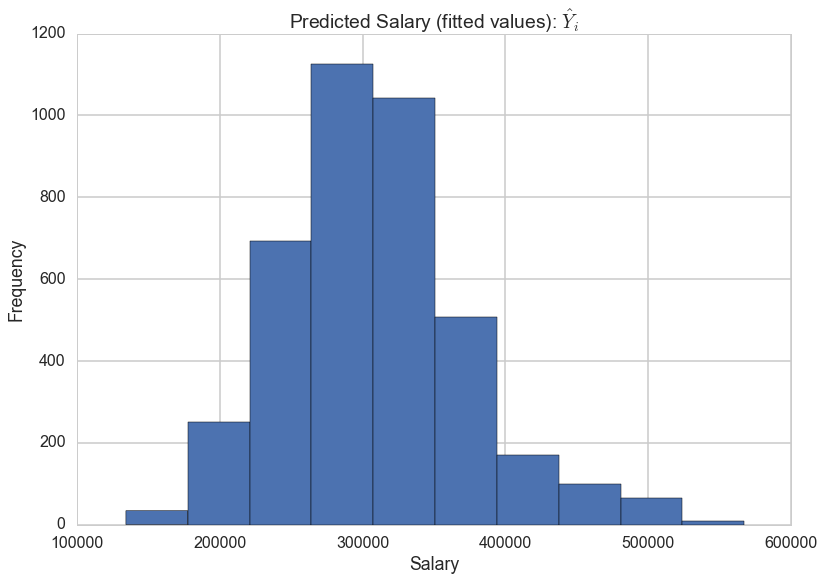

In [93]:
plt.hist(clf.predict(X))
plt.title('Predicted Salary (fitted values): $\hat{Y}_i$')
plt.xlabel('Salary')
plt.ylabel('Frequency');

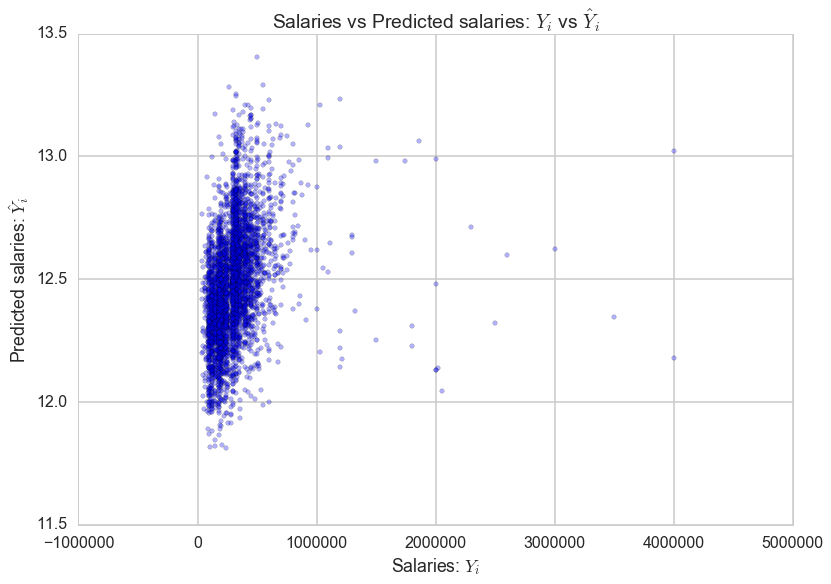

In [133]:
plt.scatter(train.salary, clf.predict(X), alpha=0.3)
plt.xlabel("Salaries: $Y_i$")
plt.ylabel("Predicted salaries: $\hat{Y}_i$")
plt.title("Salaries vs Predicted salaries: $Y_i$ vs $\hat{Y}_i$");

In [96]:
print np.sum((train.salary - clf.predict(X)) ** 2)

1.64323741929e+14


In [97]:
mseFull = np.mean((train.salary - clf.predict(X)) ** 2)
print mseFull

41101486225.4


In [98]:
# see correlations in the feature space
X.corr()

,10percentage,12percentage,collegegpa,collegetier,graduationyear,english,logical,quant,domain
10percentage,1.000000,0.643378,0.312538,-0.126042,-0.013799,0.350780,0.316014,0.317640,0.078563
12percentage,0.643378,1.000000,0.346137,-0.100771,-0.012933,0.212888,0.243571,0.312413,0.074099
collegegpa,0.312538,0.346137,1.000000,-0.086781,0.008706,0.106478,0.196610,0.217380,0.107252
collegetier,-0.126042,-0.100771,-0.086781,1.000000,-0.005557,-0.183843,-0.182811,-0.251103,-0.061436
graduationyear,-0.013799,-0.012933,0.008706,-0.005557,1.000000,-0.024089,-0.024018,-0.021781,-0.009741
english,0.350780,0.212888,0.106478,-0.183843,-0.024089,1.000000,0.444357,0.375784,0.089721
logical,0.316014,0.243571,0.196610,-0.182811,-0.024018,0.444357,1.000000,0.500152,0.169453
quant,0.317640,0.312413,0.217380,-0.251103,-0.021781,0.375784,0.500152,1.000000,0.207108
domain,0.078563,0.074099,0.107252,-0.061436,-0.009741,0.089721,0.169453,0.207108,1.000000


In [101]:
# split into training and test examples
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=44)

In [102]:
# lets print out the shape of the dataset
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(3198, 9) (800, 9) (3198L,) (800L,)


In [103]:
# lets build models
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [107]:
print "Fit a model X_train, and calculate MSE with Y_train:", np.mean((y_train - pred_train) ** 2)
print "Fit a model X_train, and calculate MSE with X_test, Y_test:", np.mean((y_test - pred_test) ** 2)

Fit a model X_train, and calculate MSE with Y_train: 41006447021.8
Fit a model X_train, and calculate MSE with X_test, Y_test: 41634066001.9


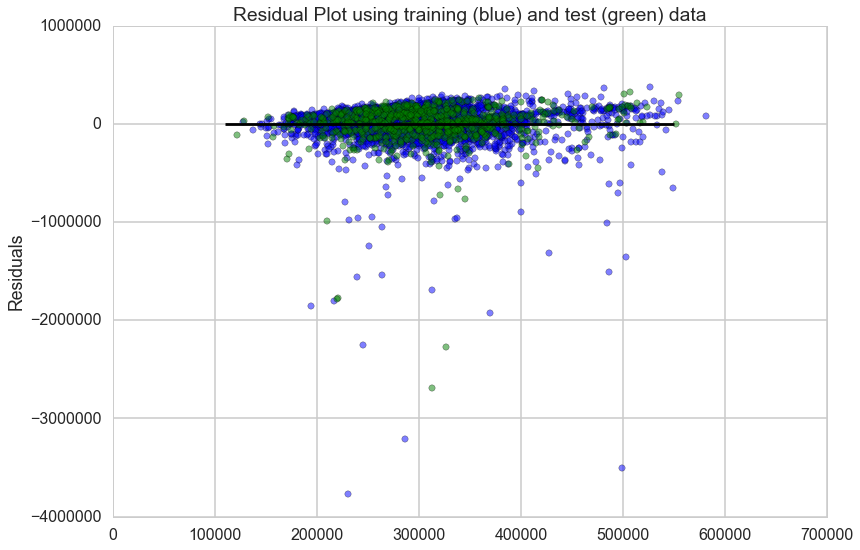

In [110]:
plt.scatter(pred_train, pred_train - y_train, c='b', s=40, alpha=0.5)
plt.scatter(pred_test, pred_test - y_test, c='g', s=40, alpha=0.5)
plt.hlines(y = 0, xmin=11e4, xmax = 55e4)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals');

In [113]:
# k-fold cross validation
from sklearn.cross_validation import KFold, cross_val_score

kf = KFold(X_train.shape[0], n_folds=5)
scores = cross_val_score(clf, X_train, y_train, scoring='mean_squared_error', cv=kf)

In [114]:
print scores.min(), scores.mean(), scores.max()

-1.0133812489e+13 -2.0623866774e+12 -24569688000.9


In [122]:
# take a logarithm of the target variable and rerun the whole analysis
X = train[features]
y = np.log1p(train.salary)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=44)

In [126]:
clf.fit(X_train, y_train)
pred_train = np.expm1(clf.predict(X_train))
pred_test = np.expm1(clf.predict(X_test))

In [127]:
pred_train

array([ 356822.35344058,  282714.06816303,  230090.10379829, ...,
        357191.77687916,  199377.94755796,  275920.62774327])

In [128]:
print "Fit a model X_train, and calculate MSE with Y_train:", np.mean((np.expm1(y_train) - pred_train) ** 2)
print "Fit a model X_train, and calculate MSE with X_test, Y_test:", np.mean((np.expm1(y_test) - pred_test) ** 2)

Fit a model X_train, and calculate MSE with Y_train: 42281132750.4
Fit a model X_train, and calculate MSE with X_test, Y_test: 43178182499.0


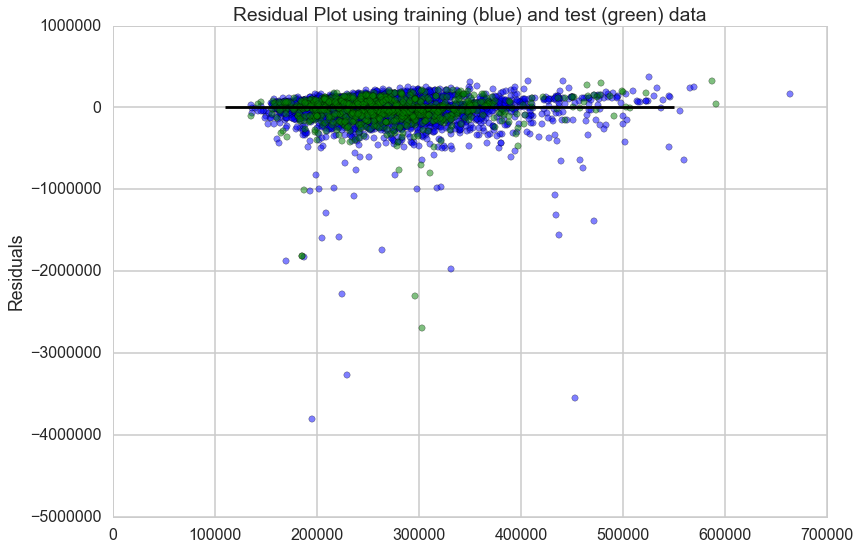

In [129]:
plt.scatter(pred_train, pred_train - np.expm1(y_train), c='b', s=40, alpha=0.5)
plt.scatter(pred_test, pred_test - np.expm1(y_test), c='g', s=40, alpha=0.5)
plt.hlines(y = 0, xmin=11e4, xmax = 55e4)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals');

** Not much improvement in mean squared error after taking log transformation **